### Forcasting airlines passengers data

In [1]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [10]:
data =pd.read_excel("Airlines+Data.xlsx", header=0, index_col=0, parse_dates=True)

In [11]:
data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1995-01-01 to 2002-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


In [13]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [14]:
data.shape

(96, 1)

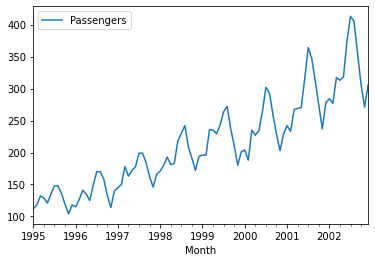

In [15]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
data.plot()
pyplot.show()

###   Time series decomposition plot 

<ipython-input-17-4ebc0e8cd6ec>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose_ts_add = seasonal_decompose(data.Passengers,freq=12)


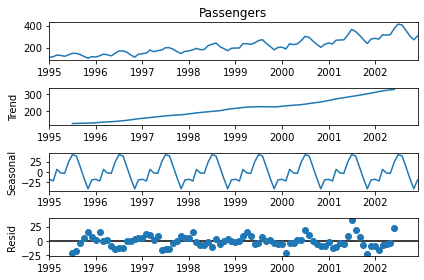

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(data.Passengers,freq=12)
decompose_ts_add.plot()
plt.show()

### Data includes the upward trend and the seasonality.

array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

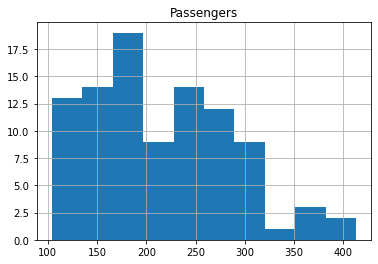

In [18]:
data.hist()

<AxesSubplot:ylabel='Density'>

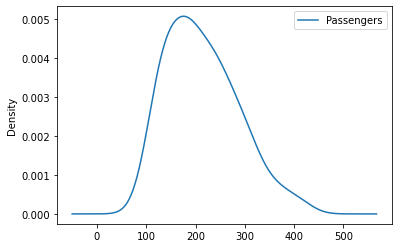

In [19]:
data.plot(kind='kde')

### Data is more in the normal distribution.

In [27]:
# separate out a validation dataset
split_point = len(data) - 10
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset1.csv', header=False)
validation.to_csv('validation1.csv', header=False)


Dataset 86, Validation 10


### Persistence/ Base model

In [28]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset1.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [24]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

### ARIMA Hyperparameters

In [29]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


### Grid search for p,d,q values

In [30]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [31]:
# load dataset
train = read_csv('dataset1.csv', header=None, index_col=0)
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=82.998
ARIMA(0, 0, 1) RMSE=46.238
ARIMA(0, 1, 0) RMSE=28.368
ARIMA(0, 1, 1) RMSE=27.592
ARIMA(0, 1, 2) RMSE=29.445
ARIMA(0, 1, 3) RMSE=25.450
ARIMA(0, 2, 0) RMSE=35.074
ARIMA(0, 2, 1) RMSE=29.153
ARIMA(0, 2, 2) RMSE=28.192
ARIMA(0, 2, 3) RMSE=29.764
ARIMA(1, 0, 0) RMSE=28.201
ARIMA(1, 0, 1) RMSE=27.042
ARIMA(1, 1, 0) RMSE=28.051
ARIMA(1, 2, 0) RMSE=34.392
ARIMA(2, 0, 0) RMSE=27.583
ARIMA(2, 1, 0) RMSE=27.643
ARIMA(2, 2, 0) RMSE=32.849
ARIMA(3, 0, 0) RMSE=27.346
ARIMA(3, 0, 1) RMSE=26.949
ARIMA(3, 1, 0) RMSE=27.875
ARIMA(3, 2, 0) RMSE=33.114
Best ARIMA(0, 1, 3) RMSE=25.450


 ### Build Model based on the optimized values

In [32]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [33]:
# load data
train = read_csv('dataset1.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

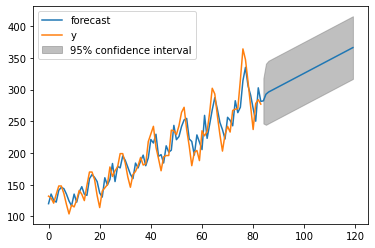

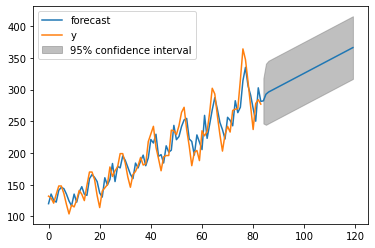

In [35]:
# fit model
model = ARIMA(X, order=(0,1,3))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 120)

In [36]:
#Error on the test data
val=pd.read_csv('validation1.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

59.2632494811665

##  ACF plots and PACF plots

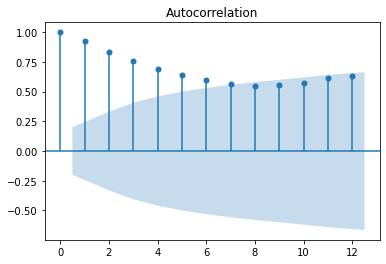

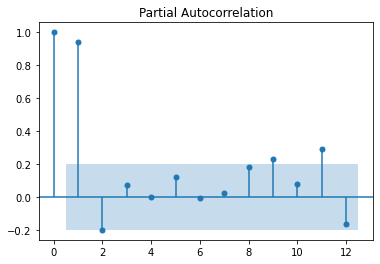

In [38]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.iloc[:,0],lags=12)
tsa_plots.plot_pacf(data.iloc[:,0],lags=12)
plt.show()


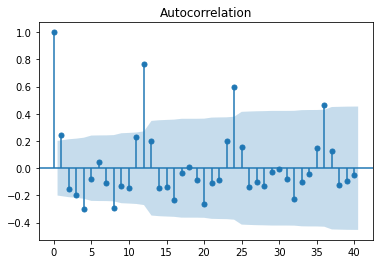

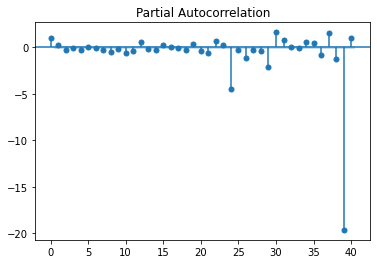

In [40]:
first_diff = data.iloc[:,0]- data.iloc[:,0].shift(1)
first_diff = first_diff.dropna(inplace = False)
tsa_plots.plot_acf(first_diff,lags=40)
tsa_plots.plot_pacf(first_diff,lags=40)
plt.show()

### In above plot we, plot the ACR and PACR for the first difference data, and we also find the seasonlaity after 12 period. 

### Combine train and test data and build final model

In [205]:
# fit model
train=pd.read_excel("Airlines+Data.xlsx", header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [191]:
model = ARIMA(X, order=(0,1,3))
model_fit = model.fit()

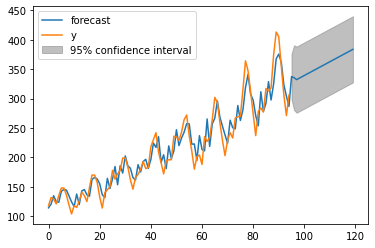

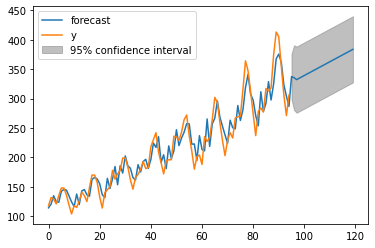

In [195]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,120)

In [196]:
forecast

array([337.36162452, 335.40397524, 332.12914558, 334.46834696,
       336.80754834, 339.14674972, 341.4859511 , 343.82515248,
       346.16435386, 348.50355524])

## Seasonal ARIMA
### As the data is seasonal, only ARIMA is not enough for predict the forcast. Therefore, here we considered the Sesonal ARIMA model.
 

In [194]:
!pip install pmdarima

In [324]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [325]:
train=pd.read_excel("Airlines+Data.xlsx", header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [326]:
X.shape

(96, 1)

In [327]:
Sarimax_model = auto_arima(X,
                       start_P=1,
                       start_q=1,
                       max_p=4,
                       max_q=4,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=621.254, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=622.012, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.965, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.628, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=618.192, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=617.814, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.881, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=616.531, Time=0.06 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=618.221, Time=0.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=617.862, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.462, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.076, Time=0.14 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=619.394, Time=0.38 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -304.983
Date:                            Sun, 19 Dec 2021   AIC                            615.965
Time:                                    00:21:37   BIC                            623.222
Sample:                                         0   HQIC                           618.881
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2250      0.099     -2.276      0.023      -0.419      -0.031
ar.S.L12      -0.2274      0.089     -2.548      0.011      -0.402      -0.052
sigma2        90.2700     14.667      6.155      0.000      61.524     119.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.97   Prob(JB):                         0.33
Heteroskedasticity (H):               1.77   Skew:                             0.39
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [328]:
model = SARIMAX(X,order=(1,1,0),
              seasonal_order=(1, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

In [329]:
forecast1 = results.predict(start = 0,
                           end=len(X)+24,
                           typ='levels')
                        

In [330]:
len(X)

96

In [331]:
forecast1

array([  0.        , 102.57028644, 118.39247246, 130.15474786,
       129.61424344, 121.95015304, 133.08557379, 146.56986837,
       148.17772376, 137.51764253, 120.99268311, 105.67702798,
       181.49479903, 132.86061636, 136.63466081, 138.3509708 ,
       128.42374849, 137.81639125, 159.24606894, 168.85562395,
       159.1879688 , 142.73063542, 121.06870754, 125.94404504,
       145.22199156, 154.81611036, 165.97785446, 169.36918711,
       155.92843602, 188.94510928, 201.04568274, 198.51992121,
       187.        , 161.65843265, 143.67267786, 168.63126284,
       169.89468368, 176.94543706, 204.26111495, 183.14686995,
       185.26821026, 193.90443173, 232.7553105 , 232.27323452,
       224.68177857, 191.01374066, 173.09688607, 194.00323115,
       198.85489587, 204.80740094, 214.59698477, 217.36768625,
       235.70467454, 259.55072854, 260.70220204, 271.41582241,
       243.56675583, 219.63499661, 194.49337144, 204.73583695,
       203.84531984, 206.06572172, 226.1665731 , 227.99

In [332]:
forecast1.shape

(121,)

In [333]:
data =pd.read_excel("Airlines+Data.xlsx",parse_dates=True)

In [334]:
data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [335]:
data.shape

(96, 2)

In [336]:
df = pd.DataFrame(forecast1, columns = ['forecast'])

In [337]:
df

,forecast
0,0.000000
1,102.570286
2,118.392472
3,130.154748
4,129.614243
...,...
116,417.941942
117,370.934468
118,335.572190
119,371.659024


<AxesSubplot:>

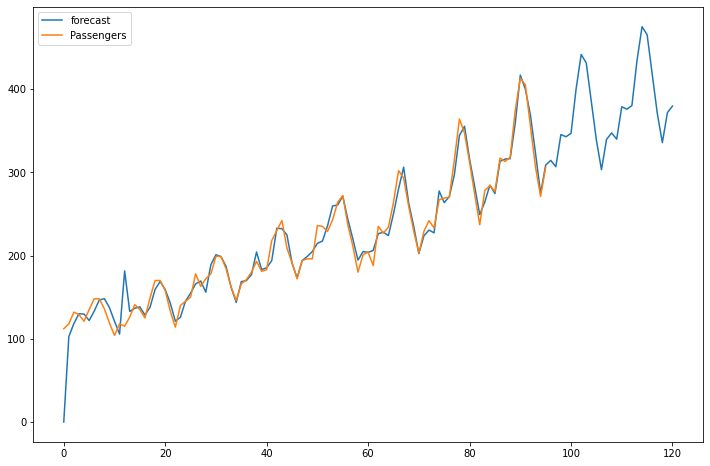

In [339]:
df.plot(legend=True)
data['Passengers'].plot(figsize=(12,8),legend=True)